In [413]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [414]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_data.csv')
sub = pd.read_csv('./data/sample_submission.csv')

# 시간 차이(문제 푸는데 걸린 시간) 계산
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train['elapsed_time'] = train['Timestamp'].astype(int)
train['elapsed_time'] = train['elapsed_time'].diff().shift(-1) // 10**9

# 바뀌는 순간 포착 (testid, userid 둘중 하나가 바뀌는 순간 포착)
train['testId2'] = train['testId'].apply(lambda x: x[1:])
train['testId2'] = (train['testId2'] + train['userID'].astype(str)).astype(int)
train['changed_point'] = train['testId2'].diff().shift(-1)
train['changed_point'] = train['changed_point'].apply(lambda x: False if x == 0 else True)
train.drop('testId2', axis=1, inplace=True)

# 카테고리 컬럼 추가
train['test_cat'] = train['testId'].apply(lambda x: x[2])

# 문제 번호 컬럼 추가
train['question_number'] = train['assessmentItemID'].apply(lambda x: x[8:10]).map(int)

In [416]:
# elapsed_time이 너무 큰 경우, threshold를 걸어줄 수도 있다. 
THRESHOLD_TIME = 200
train['elapsed_time_threshold'] = train['elapsed_time'].apply(lambda x: min(x, THRESHOLD_TIME))


# train data를 주어진 column에 대해서 groupby 하는 함수
def make_groupby(train: pd.DataFrame, group: str) -> pd.DataFrame:
    """
        answerCode: 정답률
        count: 행이 등장한 횟수
        time_mean: 걸린 시간 평균
        time_median: 걸린 시간 중간값
        time_threshold_mean: threshold 적용 후 평균
        time_threshold_median: threshold 적용 후 중간 값(time_median 이랑 동일할듯...)
    """
    df = train.groupby(group)['answerCode'].mean().to_frame()
    df['count'] = train.groupby(group)['answerCode'].count()
    
    # 시간에 대한 계산을 할 때는 제일 마지막 문제(시간 계산이 이상하게 나오는 경우)는 제외하고 계산한다. 
    df['time_mean'] = train[~train['changed_point']].groupby(group)['elapsed_time'].mean()
    df['time_median'] = train[~train['changed_point']].groupby(group)['elapsed_time'].median()
    df['time_threshold_mean'] = train[~train['changed_point']].groupby(group)['elapsed_time_threshold'].mean()
    df['time_threshold_median'] = train[~train['changed_point']].groupby(group)['elapsed_time_threshold'].median()
    
    return df

exam = make_groupby(train, 'testId')
tag = make_groupby(train, 'KnowledgeTag')
problem = make_groupby(train, 'assessmentItemID')
category = make_groupby(train, 'test_cat')
problem_13 = make_groupby(train, 'question_number')
user = make_groupby(train, 'userID')


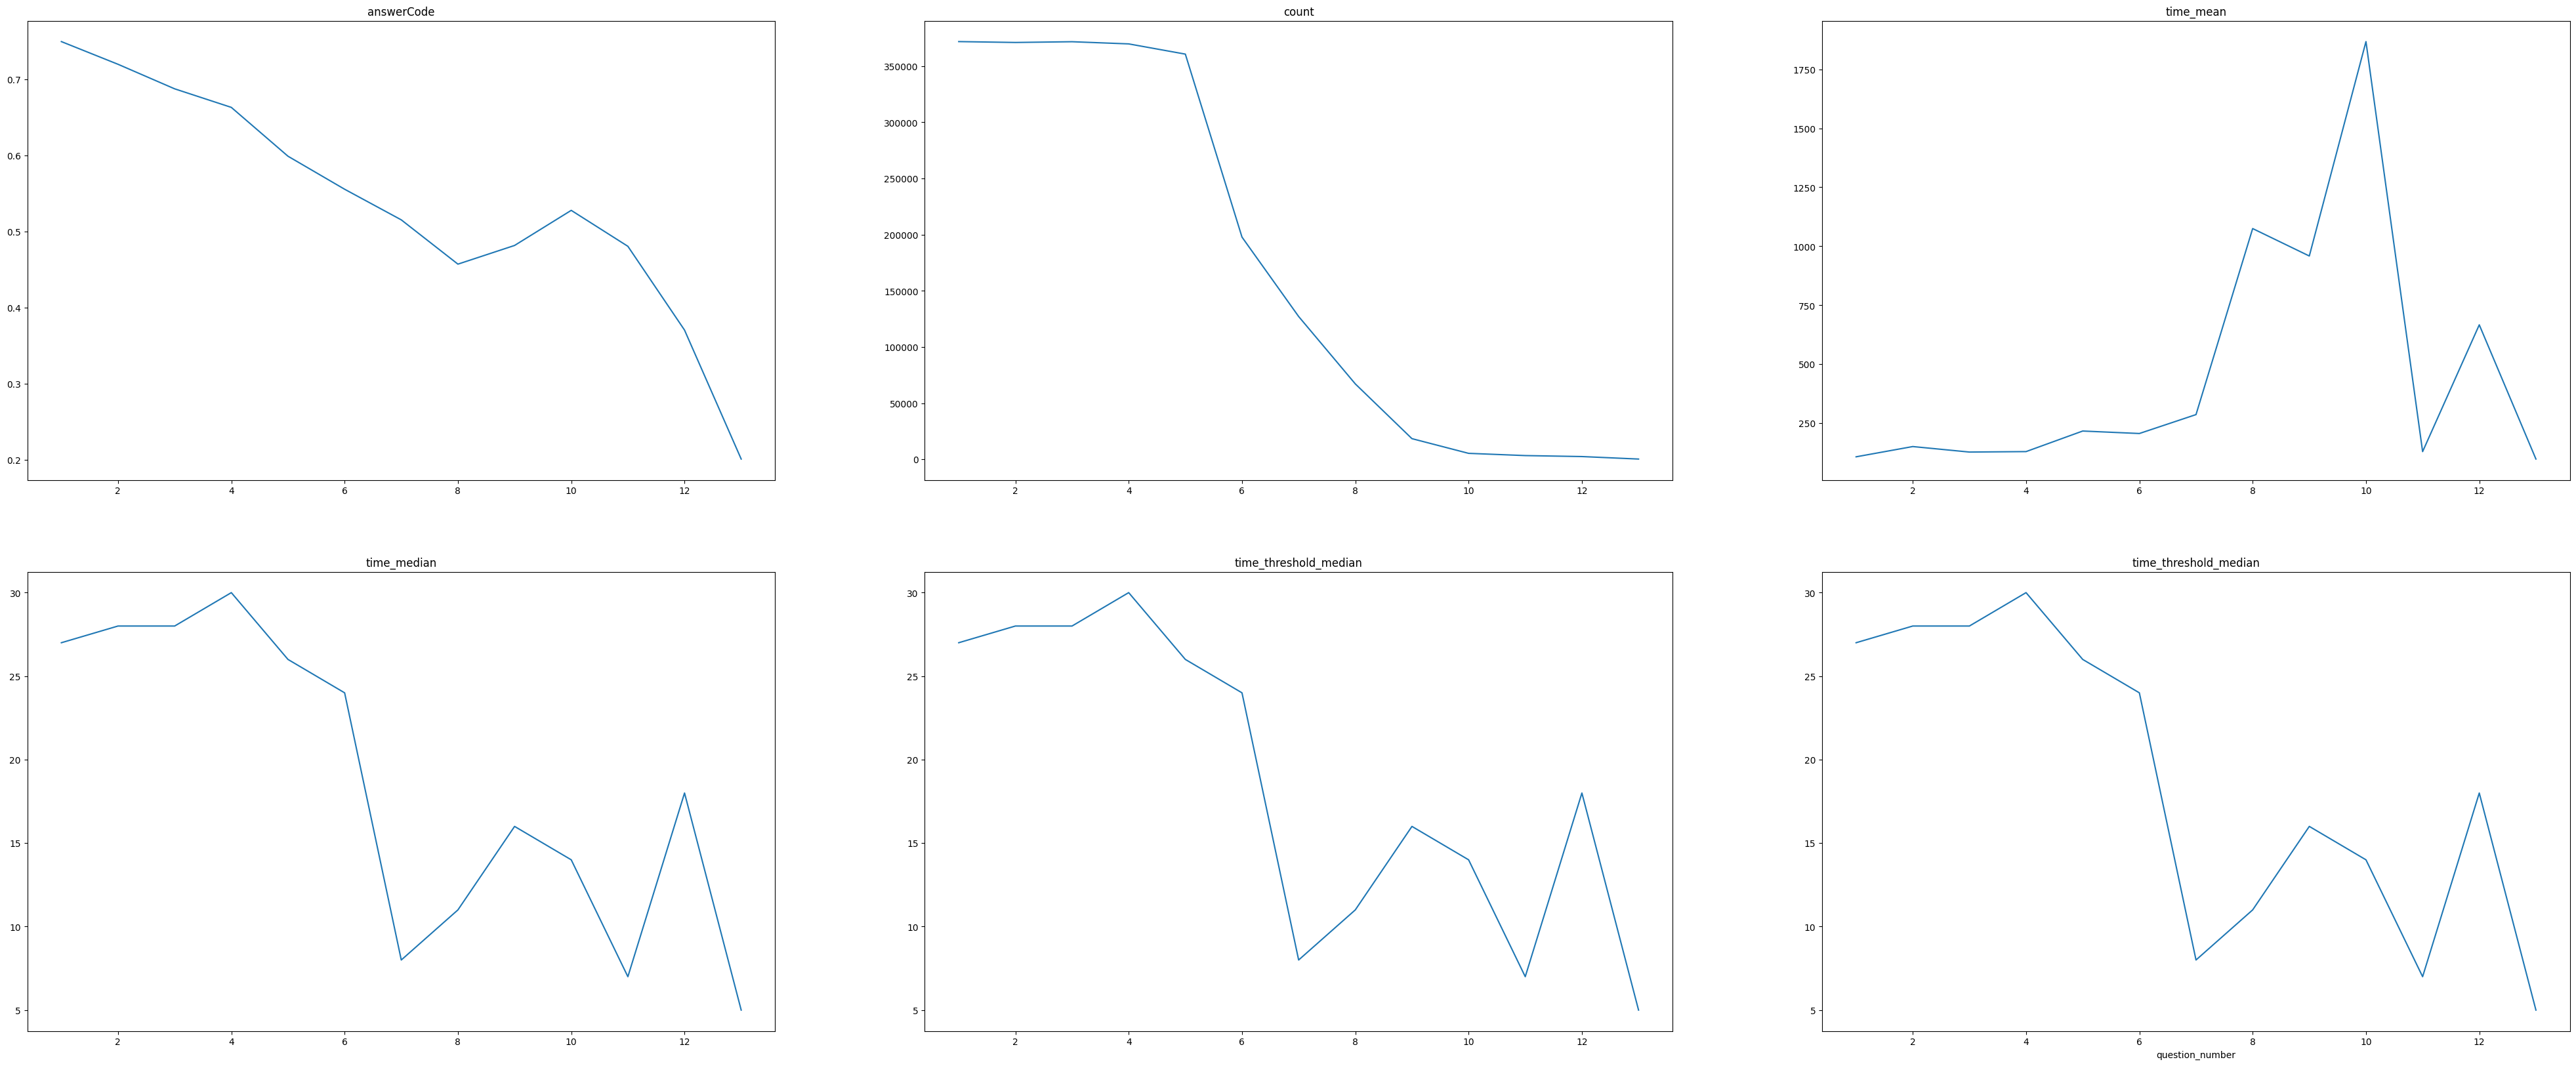

In [417]:
# 위에서 make_groupby로 만든 df들 그래프로 그려보기
def plot_multi(df: pd.DataFrame) -> None:
    fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(50, 20))
    axs[0][0].plot(df['answerCode'])
    axs[0][0].set_title('answerCode')
    
    axs[0][1].plot(df['count'])
    axs[0][1].set_title('count')
    
    axs[0][2].plot(df['time_mean'])
    axs[0][2].set_title('time_mean')
    
    axs[1][0].plot(df['time_median'])
    axs[1][0].set_title('time_median')
    
    axs[1][1].plot(df['time_threshold_median'])
    axs[1][1].set_title('time_threshold_median')
    
    axs[1][2].plot(df['time_threshold_median'])
    axs[1][2].set_title('time_threshold_median')
    
    plt.xlabel(df.index.name)
    plt.show()
    
plot_multi(problem_13)